# Some Background 

When I'm listening to music on Spotify, I generally like songs but don't really bother placing the songs into playlists. Everytime I press shuffle, it can go from Bad Bunny to Little Richard and then to Romeo Santos. Can you imagine being at the club listening to hip hop and then the next song is a country song? And the following song is a Corrido? Yep... these radical changes in genre can really throw you off. 

That's basically every single car ride for me and my dance group as we head to practice every Sunday. At this point, we just try and guess what genre is comming up next. The person who gets the most right, is usually DJ on the way back.

I'm going to use Spotify's API wrapper (Spotipy) to sort my music into playlists that have a similar genre. I will focus primarily on Hispanic genres so I will disregard music in English since most of my music is primarily Hispanic music. 


Shoutout to those new Bad Bunny albums though!! haha


# Imports

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Credentials

My credentials are stored in another file and I'm going to be importing them.

In [2]:
creds= pd.read_csv('../credentials')
SPOTIPY_CLIENT_ID = creds['Client ID'][0]
SPOTIPY_CLIENT_SECRET = creds['Client Secret'][0]
#Shameless redirect to my dance group if you're signing in for the first time
SPOTIPY_REDIRECT_URI= 'https://www.ballethermosoamanecer.com/'
username = ""

# Data Collection 

## Testing 20 Songs in Liked 

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id= SPOTIPY_CLIENT_ID, 
                                                      client_secret=SPOTIPY_CLIENT_SECRET)

sp = spotipy.Spotify(client_credentials_manager= client_credentials_manager)
scope = 'playlist-read-collaborative user-library-read playlist-read-private playlist-modify-public playlist-modify-private user-read-recently-played user-top-read'
token = util.prompt_for_user_token(username, scope, 
                                   client_id= SPOTIPY_CLIENT_ID, 
                                   client_secret= SPOTIPY_CLIENT_SECRET, 
                                   redirect_uri= SPOTIPY_REDIRECT_URI)
if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_saved_tracks()
    count = 0
    total_liked_songs = results['total']
    for item in results['items']:
        track = item['track']
        print(track['name'] + ' - ' + track['artists'][0]['name'])
        count += 1
    print(f"\nShowing {count} out of {total_liked_songs} songs")
else:
    print("Can't get token for", username)

BAD CON NICKY - Bad Bunny
La Rabia - Chuy Lizarraga y Su Banda Tierra Sinaloense
La Santa - Bad Bunny
Safaera - Bad Bunny
Qué Maldición - Banda MS de Sergio Lizárraga
Quien De Los Dos Sera - Estrellas de la Kumbia
Children of the Grave - 2014 Remaster - Black Sabbath
Tal Vez - Eslabon Armado
Disenchanted - My Chemical Romance
Iron Man - 2014 Remaster - Black Sabbath
Don't Start Now - Dua Lipa
Cuánto Me Cuesta - La Arrolladora Banda El Limón De Rene Camacho
Young, Wild & Free (feat. Bruno Mars) - Snoop Dogg
Ojalá Fuera Cierto - Christian Nodal
No Te Contaron Mal - Christian Nodal
La Cumbia para el Pueblo - Chucho Ponce Los Daddys de Chinantla
Te Amo - Piso 21
Who Can It Be Now? - Men At Work
Como los Gatos (feat. Xitlali Sarmiento) - Edwin Luna y La Trakalosa de Monterrey
Guardemos Este Secreto - Chucho Ponce Los Daddys de Chinantla

Showing 20 out of 1298 songs


## Collecting Audio Features for Liked Songs

In [4]:
song_name = []
song_uri = []
song_popularity = []
artist_name = []
artist_uri = []
genres_found = []
loops= 0 
track_audio_features = []

while results:
    for item in results['items']:
        track = item['track']
        song_name.append(track['name'])
        song_uri.append(track['uri'])
        song_popularity.append(track['popularity'])
    
        #Some songs have multuple artists so I'll make a list of artists as well as a list of uris for each song
        artist_name.append([artist['name'] for artist in track['artists']])
        artist_uri.append([artist['uri'] for artist in track['artists']])
    
        #Spotify doesn't provide the genre of the song so I have to look at the genre of the artist(s) of the song
        temp = sp.artists([artist['uri'] for artist in track['artists']])['artists']
        temp2 = []
        for temp_artists in temp:
            for genre in temp_artists['genres']:
                temp2.append(genre)
        #We only want to keep unique genres and avoid duplicate genres
        genres_found.append(list(set(temp2)))
    
    #Collecting audio features available for each song 
    #As shown from above, 20 
    track_audio_features.extend(sp.audio_features(song_uri[20*loops :20*(loops+1)]))
    print(f'Audio Features were gathered for {len(track_audio_features)} songs')

    loops += 1 
    results = sp.next(results)
    if (loops % 5) == 0 :
        print(f'{loops} cycles have been completed\n')
    #Sleep in order to not bombard with too many requests
    time.sleep(.1)

#Bringing it all together 
df_audio_feat = pd.DataFrame(track_audio_features) 
df_tracks = pd.DataFrame({'artist_uri': artist_uri,
                          'song_uri': song_uri,
                          'song_name':song_name,
                          'artists': artist_name,
                          'genres': genres_found,
                          'popularity': song_popularity})

print("\nCreating Dataframe . . .")
collected_data = pd.merge(df_tracks, df_audio_feat, left_on= 'song_uri', right_on= 'uri')
print("Complete!")

Audio Features were gathered for 20 songs
Audio Features were gathered for 40 songs
Audio Features were gathered for 60 songs
Audio Features were gathered for 80 songs
Audio Features were gathered for 100 songs
5 cycles have been completed

Audio Features were gathered for 120 songs
Audio Features were gathered for 140 songs
Audio Features were gathered for 160 songs
Audio Features were gathered for 180 songs
Audio Features were gathered for 200 songs
10 cycles have been completed

Audio Features were gathered for 220 songs
Audio Features were gathered for 240 songs
Audio Features were gathered for 260 songs
Audio Features were gathered for 280 songs
Audio Features were gathered for 300 songs
15 cycles have been completed

Audio Features were gathered for 320 songs
Audio Features were gathered for 340 songs
Audio Features were gathered for 360 songs
Audio Features were gathered for 380 songs
Audio Features were gathered for 400 songs
20 cycles have been completed

Audio Features were g

In [5]:
collected_data.head()

,artist_uri,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,"[spotify:artist:4q3ewBCX7sLwd24euuV69X, spotif...",spotify:track:5bmSver2b3ZXyuyLKtgnFI,BAD CON NICKY,"[Bad Bunny, Nicky Jam]","[latin hip hop, reggaeton, tropical, trap lati...",82,0.590,0.729,7,-4.950,...,0.6590,0.712,93.094,audio_features,5bmSver2b3ZXyuyLKtgnFI,spotify:track:5bmSver2b3ZXyuyLKtgnFI,https://api.spotify.com/v1/tracks/5bmSver2b3ZX...,https://api.spotify.com/v1/audio-analysis/5bmS...,202240,4
1,[spotify:artist:1DA8SLXtp8MMVpgaOWzMQr],spotify:track:71DHSZHV31SnXXwDu96k5N,La Rabia,[Chuy Lizarraga y Su Banda Tierra Sinaloense],"[duranguense, regional mexican pop, banda, gru...",60,0.766,0.721,8,-4.127,...,0.0691,0.960,107.015,audio_features,71DHSZHV31SnXXwDu96k5N,spotify:track:71DHSZHV31SnXXwDu96k5N,https://api.spotify.com/v1/tracks/71DHSZHV31Sn...,https://api.spotify.com/v1/audio-analysis/71DH...,193880,3
2,"[spotify:artist:4q3ewBCX7sLwd24euuV69X, spotif...",spotify:track:69vlMrzHwATKzupwNcUPyK,La Santa,"[Bad Bunny, Daddy Yankee]","[latin hip hop, reggaeton, tropical, trap lati...",84,0.744,0.868,1,-4.524,...,0.0822,0.586,93.037,audio_features,69vlMrzHwATKzupwNcUPyK,spotify:track:69vlMrzHwATKzupwNcUPyK,https://api.spotify.com/v1/tracks/69vlMrzHwATK...,https://api.spotify.com/v1/audio-analysis/69vl...,206420,4
3,"[spotify:artist:4q3ewBCX7sLwd24euuV69X, spotif...",spotify:track:2DEZmgHKAvm41k4J3R2E9Y,Safaera,"[Bad Bunny, Jowell & Randy, Ñengo Flow]","[latin hip hop, reggaeton, tropical, trap lati...",89,0.607,0.829,2,-4.074,...,0.1070,0.685,96.172,audio_features,2DEZmgHKAvm41k4J3R2E9Y,spotify:track:2DEZmgHKAvm41k4J3R2E9Y,https://api.spotify.com/v1/tracks/2DEZmgHKAvm4...,https://api.spotify.com/v1/audio-analysis/2DEZ...,295177,4
4,"[spotify:artist:2C6i0I5RiGzDKN9IAF8reh, spotif...",spotify:track:2RxC2peY3FtrurYmbbmanr,Qué Maldición,"[Banda MS de Sergio Lizárraga, Snoop Dogg]","[g funk, banda, gangster rap, rap, west coast ...",78,0.755,0.531,9,-8.051,...,0.1300,0.683,177.951,audio_features,2RxC2peY3FtrurYmbbmanr,spotify:track:2RxC2peY3FtrurYmbbmanr,https://api.spotify.com/v1/tracks/2RxC2peY3Ftr...,https://api.spotify.com/v1/audio-analysis/2RxC...,203360,4


Ideally, I want to create playlists for each genre and place the correct songs into each playlist. We're using the artist's genre as a proxy for the song's genre since Spotify doesn't provide us with specific song genres.

Given that some songs can have multiple artists, some songs might be classified under multiple genres if artists from different genres are collaborating on a song. In addition, genres provided are waaaaay too specific for my needs. To start, I will simplify my problem and classify my music into larger, umbrella genres. This will definitely capture some noise as songs can overlap generes but that's okay. I'll need to create my own training data from the data that I have collected.

After I cleaned up my data, I will explore a couple of different clustering techniques in order to see how many realistic clusters can be formed. I will use PCA in order to reduce dimensionality and see how that changes the effectiveness of my models. I will be using K-Means and DBSCAN but first, I have some data cleaning to do.  


# Data Cleaning

## Outliers and  `null` values

Let's check for `null` values and remove columns that are repetitive and/or provide no additional information. Domain knowledge usually helps identify any outliers or data points that might be off due to human error but for this case, I will assume all values provided by Spotify have no human error. 

In [6]:
collected_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1298 entries, 0 to 1297
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_uri        1298 non-null   object 
 1   song_uri          1298 non-null   object 
 2   song_name         1298 non-null   object 
 3   artists           1298 non-null   object 
 4   genres            1298 non-null   object 
 5   popularity        1298 non-null   int64  
 6   danceability      1298 non-null   float64
 7   energy            1298 non-null   float64
 8   key               1298 non-null   int64  
 9   loudness          1298 non-null   float64
 10  mode              1298 non-null   int64  
 11  speechiness       1298 non-null   float64
 12  acousticness      1298 non-null   float64
 13  instrumentalness  1298 non-null   float64
 14  liveness          1298 non-null   float64
 15  valence           1298 non-null   float64
 16  tempo             1298 non-null   float64


In [7]:
collected_data.isnull().sum()

artist_uri          0
song_uri            0
song_name           0
artists             0
genres              0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

## Checking for Duplicates 

In [8]:
collected_data[collected_data.duplicated(subset=['song_uri'])]

,artist_uri,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature


No duplicates found

## Dropping Unecessary Columns

In [9]:
collected_data.head()

,artist_uri,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,"[spotify:artist:4q3ewBCX7sLwd24euuV69X, spotif...",spotify:track:5bmSver2b3ZXyuyLKtgnFI,BAD CON NICKY,"[Bad Bunny, Nicky Jam]","[latin hip hop, reggaeton, tropical, trap lati...",82,0.590,0.729,7,-4.950,...,0.6590,0.712,93.094,audio_features,5bmSver2b3ZXyuyLKtgnFI,spotify:track:5bmSver2b3ZXyuyLKtgnFI,https://api.spotify.com/v1/tracks/5bmSver2b3ZX...,https://api.spotify.com/v1/audio-analysis/5bmS...,202240,4
1,[spotify:artist:1DA8SLXtp8MMVpgaOWzMQr],spotify:track:71DHSZHV31SnXXwDu96k5N,La Rabia,[Chuy Lizarraga y Su Banda Tierra Sinaloense],"[duranguense, regional mexican pop, banda, gru...",60,0.766,0.721,8,-4.127,...,0.0691,0.960,107.015,audio_features,71DHSZHV31SnXXwDu96k5N,spotify:track:71DHSZHV31SnXXwDu96k5N,https://api.spotify.com/v1/tracks/71DHSZHV31Sn...,https://api.spotify.com/v1/audio-analysis/71DH...,193880,3
2,"[spotify:artist:4q3ewBCX7sLwd24euuV69X, spotif...",spotify:track:69vlMrzHwATKzupwNcUPyK,La Santa,"[Bad Bunny, Daddy Yankee]","[latin hip hop, reggaeton, tropical, trap lati...",84,0.744,0.868,1,-4.524,...,0.0822,0.586,93.037,audio_features,69vlMrzHwATKzupwNcUPyK,spotify:track:69vlMrzHwATKzupwNcUPyK,https://api.spotify.com/v1/tracks/69vlMrzHwATK...,https://api.spotify.com/v1/audio-analysis/69vl...,206420,4
3,"[spotify:artist:4q3ewBCX7sLwd24euuV69X, spotif...",spotify:track:2DEZmgHKAvm41k4J3R2E9Y,Safaera,"[Bad Bunny, Jowell & Randy, Ñengo Flow]","[latin hip hop, reggaeton, tropical, trap lati...",89,0.607,0.829,2,-4.074,...,0.1070,0.685,96.172,audio_features,2DEZmgHKAvm41k4J3R2E9Y,spotify:track:2DEZmgHKAvm41k4J3R2E9Y,https://api.spotify.com/v1/tracks/2DEZmgHKAvm4...,https://api.spotify.com/v1/audio-analysis/2DEZ...,295177,4
4,"[spotify:artist:2C6i0I5RiGzDKN9IAF8reh, spotif...",spotify:track:2RxC2peY3FtrurYmbbmanr,Qué Maldición,"[Banda MS de Sergio Lizárraga, Snoop Dogg]","[g funk, banda, gangster rap, rap, west coast ...",78,0.755,0.531,9,-8.051,...,0.1300,0.683,177.951,audio_features,2RxC2peY3FtrurYmbbmanr,spotify:track:2RxC2peY3FtrurYmbbmanr,https://api.spotify.com/v1/tracks/2RxC2peY3Ftr...,https://api.spotify.com/v1/audio-analysis/2RxC...,203360,4


Notable Columns: 
- **genres**: the genre of the artist(s) of the song
- **popularity**: the higher the value the more popular the song is.
- **danceability**: The higher the value, the easier it is to dance to this song.
- **energy**: The energy of a song - the higher the value, the more energtic. song
- **key**: 
- **loudness**: The higher the value, the louder the song. Measured in dB
- **mode**                
- **speechiness**:  The higher the value the more spoken word the song contains         
- **acousticness**: The higher the value the more acoustic the song is.       
- **instrumentalness**:    
- **liveness**:   The higher the value, the more likely the song is a live recording.        
- **valence**:   The higher the value, the more positive mood for the song.           
- **tempo**:               
- **type**:                
- **track_href**:          
- **analysis_url**: additional info      


Some of the columns above won't be needed to create my training dataset so I drop the following columns. I'm renaming this new dataframe as `data` in order to differentiate the two datasets. I could keep the old name but for demonstration purposes, I'll rename it to `data`

In [10]:
data= collected_data.drop(columns= ['artist_uri', 'type','id', 'uri', 'track_href', 'analysis_url'])
data.head()

,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,spotify:track:5bmSver2b3ZXyuyLKtgnFI,BAD CON NICKY,"[Bad Bunny, Nicky Jam]","[latin hip hop, reggaeton, tropical, trap lati...",82,0.590,0.729,7,-4.950,0,0.0893,0.3210,0.000000,0.6590,0.712,93.094,202240,4
1,spotify:track:71DHSZHV31SnXXwDu96k5N,La Rabia,[Chuy Lizarraga y Su Banda Tierra Sinaloense],"[duranguense, regional mexican pop, banda, gru...",60,0.766,0.721,8,-4.127,1,0.0515,0.4450,0.000245,0.0691,0.960,107.015,193880,3
2,spotify:track:69vlMrzHwATKzupwNcUPyK,La Santa,"[Bad Bunny, Daddy Yankee]","[latin hip hop, reggaeton, tropical, trap lati...",84,0.744,0.868,1,-4.524,1,0.0470,0.0326,0.000000,0.0822,0.586,93.037,206420,4
3,spotify:track:2DEZmgHKAvm41k4J3R2E9Y,Safaera,"[Bad Bunny, Jowell & Randy, Ñengo Flow]","[latin hip hop, reggaeton, tropical, trap lati...",89,0.607,0.829,2,-4.074,1,0.3790,0.0103,0.000000,0.1070,0.685,96.172,295177,4
4,spotify:track:2RxC2peY3FtrurYmbbmanr,Qué Maldición,"[Banda MS de Sergio Lizárraga, Snoop Dogg]","[g funk, banda, gangster rap, rap, west coast ...",78,0.755,0.531,9,-8.051,0,0.1960,0.2130,0.000000,0.1300,0.683,177.951,203360,4


In [11]:
data.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000
mean,49.336672,0.684502,0.696625,5.279661,-5.889926,0.609399,0.093503,0.248212,0.026920,0.165979,0.688212,124.247806,223602.518490,3.921418
std,26.733585,0.148073,0.163038,3.657829,2.505662,0.488073,0.088702,0.228484,0.120948,0.125634,0.218240,32.679560,54683.552016,0.335493
min,0.000000,0.167000,0.092900,0.000000,-17.369000,0.000000,0.023200,0.000025,0.000000,0.011800,0.056000,48.718000,62563.000000,1.000000
25%,34.000000,0.599000,0.589250,2.000000,-7.178250,0.000000,0.039025,0.056025,0.000000,0.087125,0.549250,95.994250,188953.750000,4.000000
50%,55.500000,0.712000,0.714000,5.000000,-5.499500,1.000000,0.056650,0.176000,0.000003,0.118000,0.725500,119.293500,215891.000000,4.000000
75%,70.000000,0.793000,0.817750,9.000000,-4.200000,1.000000,0.106500,0.391750,0.000250,0.212500,0.871750,147.872250,248007.000000,4.000000
max,99.000000,0.967000,0.996000,11.000000,0.683000,1.000000,0.919000,0.984000,0.965000,0.986000,0.988000,214.017000,597720.000000,5.000000


## Simplifying Generes (Manually) 

Lets see what genres we have:

In [12]:
genre_dummied = data['genres'].str.join(sep='*').str.get_dummies(sep='*')
genre_dummied

,acoustic pop,adult standards,african percussion,afro dancehall,afro r&b,afrofuturism,afrofuturismo brasileiro,afropop,afroswing,album rock,...,viral trap,virginia hip hop,vocal jazz,welsh metal,west coast rap,west coast trap,world worship,worship,wrestling,yacht rock
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In theory, I would have 424 different playlists if I made a playlist for each genre. That's excessive and unproductive since some songs pertain to multiple genres and some genres only have one song associated with it. Lets add up our genres and see what's popular in my liked songs 

In [13]:
genre_dummied.sum().sort_values(ascending= False)

latin            404
reggaeton        267
tropical         252
pop              158
latin pop        155
                ... 
jam band           1
j-core             1
irish hip hop      1
indie rock         1
acoustic pop       1
Length: 447, dtype: int64

Given that `latin` is the most common genere, I will go back to `data` and check if any `latin` is in the list of generes. I will replace the list with `latin` in order to simplfy my process. There are multiple subgeneres like, cumbia, bachata, merenguem etc. but for the initial phase, I am focusing on latin or not latin.

--------
After initial EDA, I have to modify my problem since my songs are overwhelmingly Hispanic. I made subdivisions of the different subgenres within Hispanic music. Not as accurate but this is how I distinguish my own music tastes and this is how I want my playlists to be organized by (for the most part). I notcied that some artists do not have a genre associated with them so lets figure out why and what to do with these values 

In [14]:
bachata_salsa_merengue = {'porro','bachata', 'merengue','salsa', 'salsa peruana', 'tropical', 'timba', 'cuban rumba','dominican pop'}
artists_bsm = []

cumbia_and_mexican = {'trival','cumbia','cumbia salvadorena','gruperas inmortales' ,'cumbia villera', 
                      'cumbia sonidera', 'tejano', 'guaracha', 'cumbia paraguaya','nu-cumbia','deep cumbia sonidera', 
                      'grupera','tamborazo','banda', 'ranchera', 'mariachi', 'duranguense','guatemalan pop',
                      'cancion melodica', 'norteno-sax','regional mexican','regional mexican pop', 'corridos tumbados', 'cumbia ranchera'}
artists_cam = []

latin_reggaeton = {'rap dominicano','perreo','venezuelan hip hop','chilean hardcore','reggaeton', 
                   'dembow', 'trap latino', 'latin hip hop','panamanian pop','venezuelan indie',
                   'latin pop', 'mexican edm', 'pop romantico', 'reggaeton flow', 'colombian pop','electro latino',
                   'puerto rican pop', 'mexican pop', 'latin viral pop', 'pop catracho'}
artists_lat_reg = []

not_hispanic = {'escape room','christian music','shimmer pop','bass trap', 'indie folk', 'stomp and holler',
                'emo rap','indie pop','indie soul', 'edm', 'house', 
                'british soul', 'disco', 'funk','la pop','uk hip hop',
                'social media pop','afropop','reggae fusion','ghanaian pop','soca',
                'hip hop','pop rap', 'pop', 'hip pop', 'rap', 'chicago rap','chicago pop', 
                'meme rap', 'dancehall', 'outlaw country', 'contemporary country','indietronica', 
                'indie poptimism', 'vapor twitch','electropop', 'vapor soul','tropical house', 'dutch rock',
                'dutch pop','dutch indie', 'indie garage rock', 'experimental pop','new jersey rap', 'afro dancehall',
                'afrofuturismo brasileiro', 'baile pop', 'moombahton', 'bass house', 'electro house', 'australian pop',
                'acoustic pop', 'ninja', 'chillwave', 'francoton', 'pop urbaine', 'rap tunisien', 
                'smooth jazz', 'jazz funk', 'acid jazz'}
artists_not_his = []

rock = {'mexican rock', 'rock en espanol', 'latin rock', 'mexican rock-and-roll',
        'metalcore','screamo','rock', 'rock-and-roll', 'punk', 'alternative metal', 
        'soft rock', 'glam rock', 'piano rock', 'jamtronica', 'jam band', 'j-core', 'rock urbano mexicano', 
       'candy pop', 'emo', 'pop punk', 'pixie', 'pop emo', 'soul blues', 'vocal jazz'}
artists_rock = []

empty_index = []


In [15]:
simplified_genres = []
for i in range(len(genres_found)):
    counter_a = len(not_hispanic & set(genres_found[i]))
    counter_b = len(rock & set(genres_found[i]))
    counter_c = len(cumbia_and_mexican & set(genres_found[i]))
    counter_d = len(bachata_salsa_merengue  & set(genres_found[i]))
    counter_e = len(latin_reggaeton & set(genres_found[i]))

    count_max = max([counter_a, counter_b, counter_c, counter_d, counter_e])
    
    if count_max == 0:
        simplified_genres.append('Empty')
        empty_index.append(i)
        
    elif count_max == counter_a:    
        simplified_genres.append('Non Hispanic')
        artists_not_his.extend(artist_name[i])
        
    elif count_max == counter_b:
        simplified_genres.append('Rock')
        artists_rock.extend(artist_name[i])

        
    elif count_max == counter_c:
        simplified_genres.append('Cumbia y Musica Mexicana')
        artists_cam.extend(artist_name[i])
       
    elif count_max == counter_d:
        simplified_genres.append('Bachata Salsa y Merengue')
        artists_bsm.extend(artist_name[i])

    elif count_max == counter_e:
        simplified_genres.append('Reggaeton and Latin Pop')
        artists_lat_reg.extend(artist_name[i])



data['simplified_genre'] = simplified_genres

In [16]:
genre_dummied = data['simplified_genre'].str.get_dummies()
genre_dummied

,Bachata Salsa y Merengue,Cumbia y Musica Mexicana,Empty,Non Hispanic,Reggaeton and Latin Pop,Rock
0,0,0,0,0,1,0
1,0,1,0,0,0,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
1293,1,0,0,0,0,0
1294,1,0,0,0,0,0
1295,1,0,0,0,0,0
1296,1,0,0,0,0,0


In [17]:
genre_dummied.sum().sort_values(ascending= False) 

Cumbia y Musica Mexicana    366
Reggaeton and Latin Pop     287
Non Hispanic                284
Rock                        166
Bachata Salsa y Merengue     99
Empty                        96
dtype: int64

Looks like there are some artists that do not have genre data. I'm not sure why that is but since we used a list, it would not have appeared as a null value. Lets check out what `Empty` genre looks like

In [18]:
data[data['simplified_genre'] == 'Still Empty']

,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,simplified_genre


Oh man, it looks like I will have to manually assign them to categories. Let the listening begin. I'll reassign the simplfied genres to make sure we have no more empty. I will also add the artists to their respective artists list in case I need to use it in the future. 


After this, I'll make playlists based on some machine learning models. The bright side is that since I'm only concerned with Hispanic genres, anything with an english title will be placed into non-hispanic. 

In [19]:
artists_bsm.extend(['Kalimete','Merenglass', 'Merenglass Grupo', 'Célia', 'Jeyro', 'Judy Santos', 
                    'Orquesta los Adolecente', 'Orquesta Noche Sabrosa', 'Adrian Valdez'])
artists_cam.extend(['Grupo Dinastia Mendoza', 'Nuevo Nivel Norteño', 'Grupo Firme', 
                    'Banda Coloso','La Atrevida Banda Sierra Blanca','Grupo Novedoso',
                    'Super Máquina Musical de Guerrero', 'Sonora Dinamica De Colombia',
                    'La Conga', 'A.B. Quintanilla III Y Los Kumbia Kings', 'Ricardo Muñoz',
                    'Sonador', 'Control', 'El Amigable De Tijuana', 'Tornado','La Hija Del Mariachi',
                    'Ángela Aguilar', 'Los Kiero', 'Banda El RetoÑo', 'Grupo Kual? Dinastia Pedraza',
                    'A Mover La Colita Cumbias', "Los Karkik's", 'Grupo K-L', 'Cumbias Epcm', 'ATM',
                    'Yolanda Pérez', 'Don Cheto'])
artists_lat_reg.extend(['Jenn', 'Tatiana Hazel', 'Danny Daniel','La Montra' ,'Dj Worldwide', 
                        'John Jairo & Dj Ewduarmix', 'Beéle', 'Ovy On The Drums'])
artists_not_his.extend(['Hvrbie', 'Franklyn Watts', 'Rhiannon Roze', 'Homestead', 
                        'Chris Jobe', 'Tim Gent', 'Finatticz', 'YUNGHELLBOY', "Jo'el Monroe", 
                        'La Doña','TITUS', 'Jay Pharoah', 'Myles William', 'RØYLS', 'Ashley Clark',
                        'D Nilsz', 'K.P. & Envyi', 'Kwabii', 'Bright-D', 'Livforit', 'Tyleven', 
                        '$HYBXI', 'Enzoh Music', 'Ruhde', 'LODE', 'Saint Bandz', 'Sadio Music',
                        'Unown'])
artists_rock.extend(['Julian Velard', 'Bermudas']) 

In [20]:
for index in empty_index:
    counter_a = len(set(data.loc[index, 'artists']) & set(artists_bsm))
    counter_b = len(set(data.loc[index, 'artists']) & set(artists_cam))
    counter_c = len(set(data.loc[index, 'artists']) & set(artists_lat_reg))
    counter_d = len(set(data.loc[index, 'artists']) & set(artists_not_his))
    counter_e = len(set(data.loc[index, 'artists']) & set(artists_rock))
    count_max = max([counter_a, counter_b, counter_c, counter_d, counter_e])
    
    if count_max == 0:
        data.loc[index, 'simplified_genre'] = 'Still Empty'
        
    elif count_max == counter_a:  
        data.loc[index, 'simplified_genre'] = 'Bachata Salsa y Merengue'
        
    elif count_max == counter_b:
        data.loc[index, 'simplified_genre'] = 'Cumbia y Musica Mexicana'
        simplified_genres.append('Rock')
        artists_rock.extend(artist_name[i])

        
    elif count_max == counter_c:
        data.loc[index, 'simplified_genre'] = 'Reggaeton and Latin Pop'

       
    elif count_max == counter_d:
        data.loc[index, 'simplified_genre'] = 'Non Hispanic'

    elif count_max == counter_e:
        data.loc[index, 'simplified_genre'] = 'Rock'
        
    

This is the following compostion of my liked music. I will make playlists based on these manually selected Genres

In [21]:
data['simplified_genre'].value_counts(normalize = True)

Cumbia y Musica Mexicana    0.319723
Non Hispanic                0.233436
Reggaeton and Latin Pop     0.226502
Rock                        0.129430
Bachata Salsa y Merengue    0.083205
Still Empty                 0.007704
Name: simplified_genre, dtype: float64

In [22]:
data['simplified_genre'].value_counts()

Cumbia y Musica Mexicana    415
Non Hispanic                303
Reggaeton and Latin Pop     294
Rock                        168
Bachata Salsa y Merengue    108
Still Empty                  10
Name: simplified_genre, dtype: int64

# Playlist Creations

## Playlists (Manual Simplification) 

In [23]:
# # REMOVE PLAYLISTS CREATED (for testing again later)
# playlist_genres = set(data['simplified_genre'])
# for l in sp.current_user_playlists()['items']: 
#     if l['name'] in playlist_genres: 
#         sp.user_playlist_unfollow(user= sp.me()['id'], playlist_id= l['id'])

In [24]:
playlist_genres = set(data['simplified_genre'])
myself = sp.me()['id']
current_playlist_names = []
for l in sp.current_user_playlists()['items']: 
    current_playlist_names.append(l['name'])
print(current_playlist_names)

['Rock', 'Cumbia y Musica Mexicana', 'Non Hispanic', 'Still Empty', 'Reggaeton and Latin Pop', 'Bachata Salsa y Merengue', 'Confidence Boost', 'Liked from Radio', '¡Viva Latino!', 'BHA Random Mix 😅', 'Best Podcasts of the Week', 'COVID-19 Quarantine Party', 'Distrito Indie', 'Best of the Decade For You', 'allnighters', 'BHA🇲🇽', 'Discover Weekly']


In [25]:
for i in playlist_genres: 
    if i not in current_playlist_names:
        playlist_name = i
        description = f'Using Python to Manually Sort Liked Songs pertaining to "{i}" genres'
        ls_songs_uri = list(data[data['simplified_genre'] == i]['song_uri'])
        playlist = sp.user_playlist_create(user= myself, name = playlist_name, description= description)
        current_playlist_names.append(playlist['name'])
        print(f'{playlist_name} has been created')
        play_id = playlist['id']
        loops = (len(ls_songs_uri) // 50) + 1
        for k in range(loops):
            print(f'adding songs from {50*k} to {50*k+1}')
            sp.user_playlist_add_tracks(user = myself, playlist_id= play_id, tracks= ls_songs_uri[(50*k) : (50 *(k+1))])
            print('done')



## Playlists (Using KMeans) 

In [26]:
#only want to keep numeric values
X = data.drop(columns= ['song_uri', 'song_name','artists','genres', 'simplified_genre'])
#scaling everything since KMeans is sensitive to distance
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [27]:
km = KMeans(n_clusters=5, random_state=42)
km.fit(X_sc)

KMeans(n_clusters=5, random_state=42)

In [28]:
km.labels_

array([1, 4, 4, ..., 4, 1, 1], dtype=int32)

In [29]:
data['Kmeans_cluster'] = km.labels_
data

,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,simplified_genre,Kmeans_cluster
0,spotify:track:5bmSver2b3ZXyuyLKtgnFI,BAD CON NICKY,"[Bad Bunny, Nicky Jam]","[latin hip hop, reggaeton, tropical, trap lati...",82,0.590,0.729,7,-4.950,0,0.0893,0.3210,0.000000,0.6590,0.712,93.094,202240,4,Reggaeton and Latin Pop,1
1,spotify:track:71DHSZHV31SnXXwDu96k5N,La Rabia,[Chuy Lizarraga y Su Banda Tierra Sinaloense],"[duranguense, regional mexican pop, banda, gru...",60,0.766,0.721,8,-4.127,1,0.0515,0.4450,0.000245,0.0691,0.960,107.015,193880,3,Cumbia y Musica Mexicana,4
2,spotify:track:69vlMrzHwATKzupwNcUPyK,La Santa,"[Bad Bunny, Daddy Yankee]","[latin hip hop, reggaeton, tropical, trap lati...",84,0.744,0.868,1,-4.524,1,0.0470,0.0326,0.000000,0.0822,0.586,93.037,206420,4,Reggaeton and Latin Pop,4
3,spotify:track:2DEZmgHKAvm41k4J3R2E9Y,Safaera,"[Bad Bunny, Jowell & Randy, Ñengo Flow]","[latin hip hop, reggaeton, tropical, trap lati...",89,0.607,0.829,2,-4.074,1,0.3790,0.0103,0.000000,0.1070,0.685,96.172,295177,4,Reggaeton and Latin Pop,2
4,spotify:track:2RxC2peY3FtrurYmbbmanr,Qué Maldición,"[Banda MS de Sergio Lizárraga, Snoop Dogg]","[g funk, banda, gangster rap, rap, west coast ...",78,0.755,0.531,9,-8.051,0,0.1960,0.2130,0.000000,0.1300,0.683,177.951,203360,4,Non Hispanic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,spotify:track:0HDHY6RSHHG2ZTE0cMT4GJ,Los Infieles,[Aventura],"[latin hip hop, latin pop, tropical, latin, ba...",71,0.745,0.716,9,-8.221,0,0.0411,0.2020,0.000000,0.0590,0.817,132.932,257187,4,Bachata Salsa y Merengue,1
1294,spotify:track:2XYkvc4UWMO9U2iQcIjJe7,Te Extraño - Bachata Version,[Xtreme],"[bachata, latin, tropical]",0,0.793,0.592,6,-4.749,0,0.0344,0.7600,0.000000,0.0876,0.892,129.960,213973,4,Bachata Salsa y Merengue,1
1295,spotify:track:0wDEs6WvqDHq4XJZC0dHhO,Hoja En Blanco,"[Monchy & Alexandra, Alexandra]","[bachata, latin, tropical]",64,0.932,0.772,0,-3.599,1,0.0369,0.2250,0.000003,0.1760,0.863,135.063,307200,4,Bachata Salsa y Merengue,4
1296,spotify:track:6I86RF3odBlcuZA9Vfjzeq,Eres Mía,[Romeo Santos],"[bachata, latin, tropical]",74,0.843,0.729,6,-3.634,0,0.0374,0.4010,0.000001,0.2060,0.903,123.046,250640,4,Bachata Salsa y Merengue,1


In [30]:
scores = []
for k in range(2, 51):
    cl = KMeans(n_clusters=k)
    cl.fit(X_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X_sc, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

In [31]:
score_df.head()

,k,inertia,silhouette
0,2,16455.512671,0.125362
1,3,15348.151859,0.101867
2,4,14302.047178,0.107640
3,5,13511.676021,0.107238
4,6,12762.543531,0.096659


Text(0.5, 1.0, 'Silhouette Score over k')

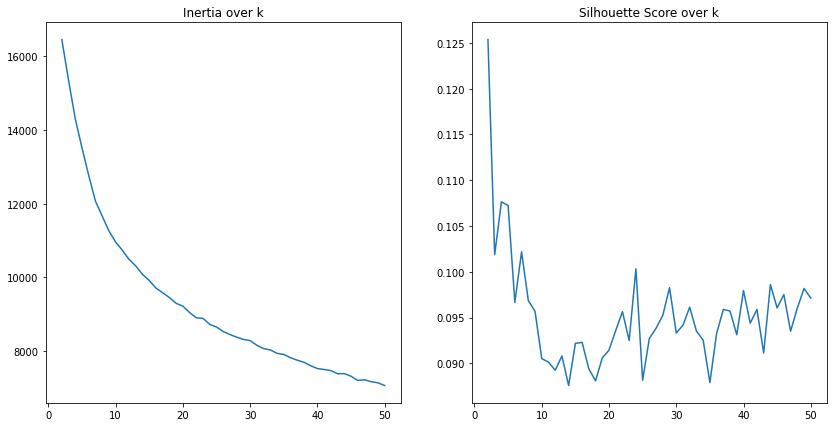

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')

Based on these graphs, I can conclude that KMeans is not suitable because you would be able to see a sharp decrease and then a flattening out. There is no "elbow" in the inertia plot. The sharp decrease is seen in the silhouette score but the silhouette score is so low, KMeans is not useful for identifying clusters in this dataset. We will have to explore other options. 

## Playlists (Using KMeans) - Including PCA

In [33]:
pca = PCA(n_components= 3)
pca.fit(X_sc)

PCA(n_components=3)

In [34]:
new_X = pca.transform(X_sc)

In [35]:
pca_km = KMeans(n_clusters=5, random_state=42)
pca_km.fit(new_X)

KMeans(n_clusters=5, random_state=42)

In [36]:
data['Kmeans_cluster_pca'] = pca_km.labels_
data

,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,simplified_genre,Kmeans_cluster,Kmeans_cluster_pca
0,spotify:track:5bmSver2b3ZXyuyLKtgnFI,BAD CON NICKY,"[Bad Bunny, Nicky Jam]","[latin hip hop, reggaeton, tropical, trap lati...",82,0.590,0.729,7,-4.950,0,...,0.3210,0.000000,0.6590,0.712,93.094,202240,4,Reggaeton and Latin Pop,1,2
1,spotify:track:71DHSZHV31SnXXwDu96k5N,La Rabia,[Chuy Lizarraga y Su Banda Tierra Sinaloense],"[duranguense, regional mexican pop, banda, gru...",60,0.766,0.721,8,-4.127,1,...,0.4450,0.000245,0.0691,0.960,107.015,193880,3,Cumbia y Musica Mexicana,4,1
2,spotify:track:69vlMrzHwATKzupwNcUPyK,La Santa,"[Bad Bunny, Daddy Yankee]","[latin hip hop, reggaeton, tropical, trap lati...",84,0.744,0.868,1,-4.524,1,...,0.0326,0.000000,0.0822,0.586,93.037,206420,4,Reggaeton and Latin Pop,4,3
3,spotify:track:2DEZmgHKAvm41k4J3R2E9Y,Safaera,"[Bad Bunny, Jowell & Randy, Ñengo Flow]","[latin hip hop, reggaeton, tropical, trap lati...",89,0.607,0.829,2,-4.074,1,...,0.0103,0.000000,0.1070,0.685,96.172,295177,4,Reggaeton and Latin Pop,2,2
4,spotify:track:2RxC2peY3FtrurYmbbmanr,Qué Maldición,"[Banda MS de Sergio Lizárraga, Snoop Dogg]","[g funk, banda, gangster rap, rap, west coast ...",78,0.755,0.531,9,-8.051,0,...,0.2130,0.000000,0.1300,0.683,177.951,203360,4,Non Hispanic,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,spotify:track:0HDHY6RSHHG2ZTE0cMT4GJ,Los Infieles,[Aventura],"[latin hip hop, latin pop, tropical, latin, ba...",71,0.745,0.716,9,-8.221,0,...,0.2020,0.000000,0.0590,0.817,132.932,257187,4,Bachata Salsa y Merengue,1,2
1294,spotify:track:2XYkvc4UWMO9U2iQcIjJe7,Te Extraño - Bachata Version,[Xtreme],"[bachata, latin, tropical]",0,0.793,0.592,6,-4.749,0,...,0.7600,0.000000,0.0876,0.892,129.960,213973,4,Bachata Salsa y Merengue,1,1
1295,spotify:track:0wDEs6WvqDHq4XJZC0dHhO,Hoja En Blanco,"[Monchy & Alexandra, Alexandra]","[bachata, latin, tropical]",64,0.932,0.772,0,-3.599,1,...,0.2250,0.000003,0.1760,0.863,135.063,307200,4,Bachata Salsa y Merengue,4,3
1296,spotify:track:6I86RF3odBlcuZA9Vfjzeq,Eres Mía,[Romeo Santos],"[bachata, latin, tropical]",74,0.843,0.729,6,-3.634,0,...,0.4010,0.000001,0.2060,0.903,123.046,250640,4,Bachata Salsa y Merengue,1,3


In [37]:
scores = []
for k in range(2, 51):
    cl = KMeans(n_clusters=k)
    cl.fit(new_X)
    inertia = cl.inertia_
    sil = silhouette_score(new_X, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

In [38]:
score_df.head()

,k,inertia,silhouette
0,2,4831.536151,0.289968
1,3,3785.060905,0.277655
2,4,3035.985620,0.267325
3,5,2680.890178,0.246303
4,6,2430.574556,0.234124


Text(0.5, 1.0, 'Silhouette Score over k')

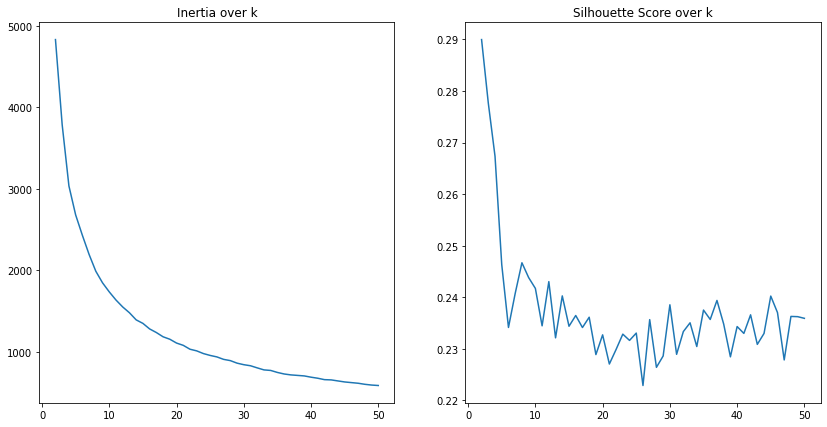

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')

In [40]:
# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 3 components): {np.round(var_exp[:3],3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 3 components): {np.round(cum_var_exp[:3],3)}')

Explained variance (first 3 components): [0.148 0.111 0.101]

Cumulative explained variance (first 3 components): [0.148 0.259 0.36 ]


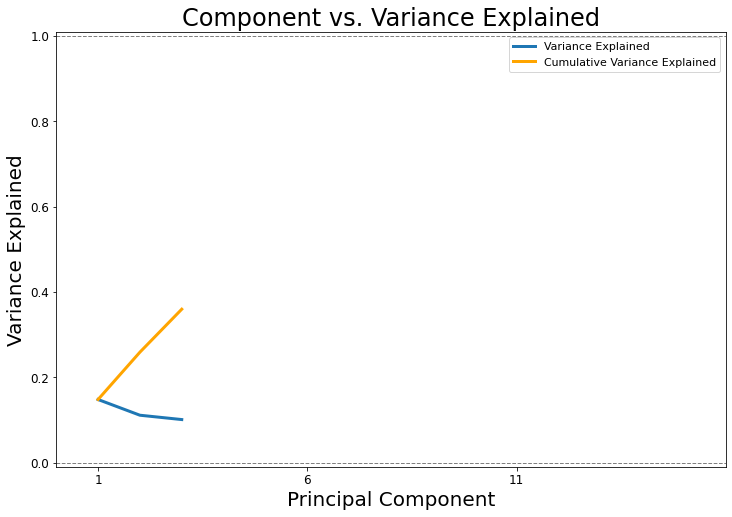

In [41]:
# Plot the variance explained (and cumulative variance explained).

# Set figure size.
plt.figure(figsize=(12,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,15])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 15, 5), range(1, 15, 5), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

PCA isn't really useful since we need more than three components to explain most of the variance. Although the silhouette score improved, only 36.8% of the variance is explained by our model. This confirmed that we definitely need to use another type of clustering algorithm 

## Playlists (Using DBSCAN) 

In [42]:
#scaling everything since DBSCAN is sensitive to distance
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [43]:
dbscan = DBSCAN(eps= 6, min_samples= 1)
dbscan.fit(X_sc);
set(dbscan.labels_)

{0, 1, 2}

In [44]:
silhouette_score(X_sc, dbscan.labels_)

0.4854111900976632

In [45]:
dbscan = DBSCAN(eps= 4, min_samples= 2)
dbscan.fit(X_sc);
set(dbscan.labels_)

{-1, 0, 1, 2}

In [46]:
silhouette_score(X_sc, dbscan.labels_)

0.4163146378631089

In [47]:
dbscan = DBSCAN(eps= 3, min_samples= 2)
dbscan.fit(X_sc);
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4, 5}

In [48]:
silhouette_score(X_sc, dbscan.labels_)

0.11216978496933985

In [49]:
dbscan = DBSCAN(eps= 2, min_samples= 5)
dbscan.fit(X_sc);
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6}

In [50]:
silhouette_score(X_sc, dbscan.labels_)

-0.10576312725841176

I need to find a systemic way to test various combinations and find the optimal hyperparameters 

In [51]:
min_samples = []
eps = []
labels = []
for samp in range(0,50): 
    for ep in range(1,80):
        dbscan = DBSCAN(eps=ep, min_samples= samp)
        dbscan.fit(X_sc)
        min_samples.append(samp)
        eps.append(ep)
        if set(dbscan.labels_): 
            labels.append(set(dbscan.labels_))
        else:
            labels.append("NO LABELS")
            
df_dbscan = pd.DataFrame({'min_samples': min_samples,
                          'epsilon': eps,
                          'labels': labels})

In [52]:
df_dbscan

,min_samples,epsilon,labels
0,0,1,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,0,2,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,0,3,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,0,4,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,0,5,"{0, 1, 2, 3}"
...,...,...,...
3945,49,75,{0}
3946,49,76,{0}
3947,49,77,{0}
3948,49,78,{0}


# Actionable Next Steps 

It seems like I was able to do this pretty efficiently for myself. There is a large portion of Hispanic users who might want to sort their music by Hispanic subgenres (Bachata, Merengue, Cumbia, etc) but haven't found an easy way to sort their music. A couple of older family members are new to technology and if I can scale this up, this could potentially be used to sort music.